<a href="https://colab.research.google.com/github/kregier/AudioLanguageClassifer/blob/main/DataWranglingEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio Language Classsifier
Identify the gender and/or native language of speakers reading a fixed passage in English.

The goal is to use the pre-trained vggish model to extract features from audio files, and train a classifier to identify the gender and/or native language or the speaker.

The data is a subset of the Speech Accent Archive, available from https://www.kaggle.com/rtatman/speech-accent-archive

In [2]:
# Set up the environment
!pip install pyAudioAnalysis
!pip install hmmlearn
!pip install eyed3
!pip install pydub
!pip install soundfile

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import IPython.display as ipd
import librosa
import librosa.display

from pyAudioAnalysis import audioSegmentation as aS

import os
import random

import tensorflow as tf
import tensorflow_hub as hub

from keras.layers import Dense
from keras.models import Sequential

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

print("All set up!")

     |████████████████████████████████| 52.4MB 81kB/s 
  Created wheel for pyAudioAnalysis: filename=pyAudioAnalysis-0.3.6-cp36-none-any.whl size=52589856 sha256=523f4568f7090101efb92b57907f82844643dc75c570d95000dbdfab84c843c7
  Stored in directory: /root/.cache/pip/wheels/fd/74/c2/361da76b03ed9d45c1b606d8fd25ac53ab965f754061fc4805
Successfully built pyAudioAnalysis
     |████████████████████████████████| 368kB 4.9MB/s 
     |████████████████████████████████| 153kB 4.3MB/s 
All set up!


# Data wrangling
## Load the data and metadata

In [3]:
# Set up the data import using Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

# Change working directory
%cd /content/gdrive/My Drive/Kaggle
!ls

/content/gdrive/My Drive/Kaggle
data  kaggle.json  reading-passage.txt	recordings  speakers_all.csv


In [ ]:
# Copy Kaggle API command - only needs to be done the first time
#!kaggle datasets download -d rtatman/speech-accent-archive

In [ ]:
# unzip the zip files and remove the zip files - only needs to be done the first time
#!unzip \*.zip && rm *.zip

In [5]:
text = pd.read_csv('reading-passage.txt', header=None, delimiter='.')
text.head().T

,0
0,Please call Stella
1,Ask her to bring these things with her from ...
2,We also need a small plastic snake and a big...
3,She can scoop these things into three red ba...
4,NaN


In [6]:
meta = pd.read_csv('speakers_all.csv')
meta.head()

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,24.0,12.0,"koussi, senegal",balanta,balanta,male,788,senegal,True,NaN,NaN,NaN
1,18.0,10.0,"buea, cameroon",cameroon,cameroon,male,1953,cameroon,True,NaN,NaN,NaN
2,48.0,8.0,"hong, adamawa, nigeria",fulfulde,fulfulde,male,1037,nigeria,True,NaN,NaN,NaN
3,42.0,42.0,"port-au-prince, haiti",haitian,haitian,male,1165,haiti,True,NaN,NaN,NaN
4,40.0,35.0,"port-au-prince, haiti",haitian,haitian,male,1166,haiti,True,NaN,NaN,NaN


In [7]:
# Drop 3 end columns with NaN values
meta.drop(['Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11'], axis=1, inplace=True)

# Set speakerid as index
meta.set_index('speakerid', inplace=True)
meta.sort_index(inplace=True)
meta.head()

,age,age_onset,birthplace,filename,native_language,sex,country,file_missing?
speakerid,,,,,,,,
1,27.0,9.0,"virginia, south africa",afrikaans1,afrikaans,female,south africa,False
2,40.0,5.0,"pretoria, south africa",afrikaans2,afrikaans,male,south africa,False
3,25.0,15.0,"diekabo, ivory coast",agni1,agni,male,ivory coast,False
4,19.0,6.0,"prishtina, kosovo",albanian1,albanian,male,kosovo,False
5,33.0,15.0,"tirana, albania",albanian2,albanian,male,albania,False


# EDA
- How many speakers per native language?
- What are the top languages present in the database?
- What is the distribution of speakers by gender and language?
- How many dialects of English are represented? (native_language == English, by birthplace and country values)


In [8]:
# How many unique values are there per column?
meta.nunique()

age                  80
age_onset            59
birthplace         1290
filename           2156
native_language     214
sex                   3
country             176
file_missing?         2
dtype: int64

In [9]:
# How many columns have null values?
meta.isnull().sum()

age                0
age_onset          0
birthplace         4
filename           0
native_language    0
sex                0
country            5
file_missing?      0
dtype: int64

In [10]:
meta[meta.birthplace.isnull()]

,age,age_onset,birthplace,filename,native_language,sex,country,file_missing?
speakerid,,,,,,,,
355,0.0,0.0,NaN,synthesized1,synthesized,male,NaN,False
356,0.0,0.0,NaN,synthesized2,synthesized,female,NaN,False
357,0.0,0.0,NaN,synthesized3,synthesized,female,NaN,False
358,0.0,0.0,NaN,synthesized4,synthesized,male,NaN,False


In [11]:
meta[meta.country.isnull()]

,age,age_onset,birthplace,filename,native_language,sex,country,file_missing?
speakerid,,,,,,,,
249,25.0,21.0,"vientiane, laos,",lao2,lao,female,NaN,False
355,0.0,0.0,NaN,synthesized1,synthesized,male,NaN,False
356,0.0,0.0,NaN,synthesized2,synthesized,female,NaN,False
357,0.0,0.0,NaN,synthesized3,synthesized,female,NaN,False
358,0.0,0.0,NaN,synthesized4,synthesized,male,NaN,False


It makes sense that the synthesized audio files would not have birthplace or country information, since a synthesized voice would not have a birthplace or country.
Since I want to train the model on real voices, I will delete the synthesized voices from the data.

In [12]:
meta.dropna(subset=['birthplace'], inplace=True)
meta[meta.native_language=='lao']

,age,age_onset,birthplace,filename,native_language,sex,country,file_missing?
speakerid,,,,,,,,
248,19.0,12.0,"savannakhet, laos",lao1,lao,female,laos,False
249,25.0,21.0,"vientiane, laos,",lao2,lao,female,NaN,False
2007,52.0,20.0,"pakxe, laos",lao3,lao,male,laos,False


The remaining missing value is in the country column from one Lao speaker. Since the other two Lao speakers have Laos as their country, I will impute Laos as the country value for the remaining speaker as well.

In [13]:
meta.loc[meta.country.isnull(), 'country'] = 'laos'
meta.isnull().sum()

age                0
age_onset          0
birthplace         0
filename           0
native_language    0
sex                0
country            0
file_missing?      0
dtype: int64

In [14]:
meta.shape

(2168, 8)

### Missing files
What are the missing files? If there are missing audio files, they will not be available for feature extraction, so they should be removed from the dataframe before the audio files are processed.

In [15]:
meta['file_missing?'].value_counts()

False    2136
True       32
Name: file_missing?, dtype: int64

In [16]:
missingIdx = meta[meta['file_missing?']==True].index
meta.loc[missingIdx].head()

,age,age_onset,birthplace,filename,native_language,sex,country,file_missing?
speakerid,,,,,,,,
318,28.0,11.0,"colombo, sri lanka",sinhalese2,sinhalese,female,sri lanka,True
380,38.0,4.0,"madang, madang province, papua new guinea",tok,tok,male,papua new guinea,True
425,25.0,5.0,"jammu, kashmir, india",poonchi1,poonchi,male,india,True
461,25.0,8.0,"colombo, sri lanka",sinhalese3,sinhalese,female,sri lanka,True
493,21.0,10.0,"eischoll, switzerland",swiss,swiss,male,switzerland,True


In [17]:
# Remove records with missing files - The files don't have unique names, and are not available in the recordings folder.
meta.drop(missingIdx, inplace=True )
meta.shape

(2136, 8)

In [18]:
# Based on trying to load the files in previous runs, these audio files are missing, so the records should be removed.
nica_index = meta[meta.filename == 'nicaragua'].index
sinhalese_index = meta[meta.filename=='sinhalese1'].index
meta.drop(nica_index, inplace=True, axis=0)
meta.drop(sinhalese_index, inplace=True, axis=0)
meta.shape

(2134, 8)

### How many speakers per native language?

In [19]:
# How many native languages, total?
meta.native_language.nunique()

199

In [20]:
# Hard to see the scope because there are so many with only one speaker
meta.native_language.value_counts()

english        579
spanish        162
arabic         102
mandarin        65
french          63
              ... 
serer            1
mortlockese      1
sundanese        1
cebuano          1
ashanti          1
Name: native_language, Length: 199, dtype: int64

In [21]:
# How many native languages with only one speaker in the database?
meta.native_language.value_counts().loc[meta.native_language.value_counts() == 1]

frisian           1
luxembourgeois    1
hainanese         1
tatar             1
hakka             1
                 ..
serer             1
mortlockese       1
sundanese         1
cebuano           1
ashanti           1
Name: native_language, Length: 78, dtype: int64

There are 78 native languages represented by only one speaker in the database. This means there are 121 languages represented by 2 or more speakers.

### What are the top 10 languages in the data, in addition to English?

In [22]:
lang_counts = meta.native_language.value_counts().head(11)
lang_counts

english       579
spanish       162
arabic        102
mandarin       65
french         63
korean         52
russian        48
portuguese     48
dutch          47
turkish        37
german         36
Name: native_language, dtype: int64

In [23]:
lang_list = ['spanish', 'arabic', 'mandarin', 'french', 'korean', 'russian', 
             'portuguese', 'dutch', 'turkish', 'german']
top_lang = meta.loc[meta.native_language.isin(lang_list)]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

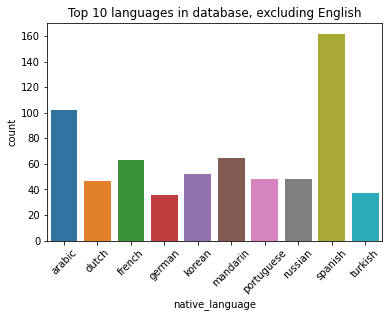

In [24]:
sns.countplot(x='native_language', data=top_lang)
plt.title('Top 10 languages in database, excluding English')
plt.xticks(rotation=45)

### What is the distribution of speakers by gender?

In [25]:
# There is one record with 'famale', which is assumed to be a typo.
type_idx = meta[meta.sex =='famale'].index
meta.loc[type_idx, 'sex'] = 'female'
meta.sex.value_counts()

male      1100
female    1034
Name: sex, dtype: int64

Text(0.5, 1.0, 'Distibution of speakers by gender - All')

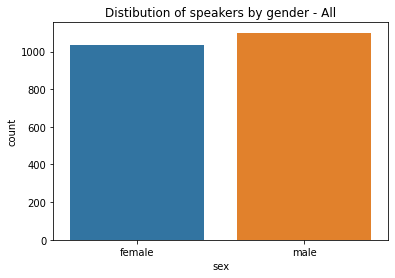

In [26]:
sns.countplot(x='sex', data=meta)
plt.title('Distibution of speakers by gender - All')

Text(0.5, 1.0, 'Distribution of speakers by gender - Top 10')

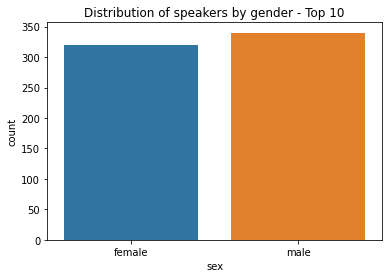

In [27]:
sns.countplot(x='sex', data=top_lang)
plt.title('Distribution of speakers by gender - Top 10')

### How many varieties of (native) Engish are represented in the database?
While we don't know which varieity of English the native speakers use, we can infer the variety by looking at their birthplace and country.

In [28]:
# How many varieties of English are represented in the database?
english = meta.loc[meta.native_language == 'english']
english.country.value_counts()

usa                     373
uk                       65
canada                   44
australia                32
ireland                  11
new zealand               8
jamaica                   5
singapore                 4
south africa              4
panama                    3
india                     3
malaysia                  2
philippines               2
guyana                    2
fiji                      1
virginia                  1
germany                   1
us virgin islands         1
nigeria                   1
liberia                   1
pakistan                  1
switzerland               1
bolivia                   1
spain                     1
the bahamas               1
lebanon                   1
trinidad                  1
antigua and barbuda       1
united arab emirates      1
italy                     1
isle of man               1
barbados                  1
papua new guinea          1
belize                    1
ghana                     1
Name: country, dtype

In [29]:
english.country.nunique()

35

Text(0.5, 1.0, 'Native English speakers by country')

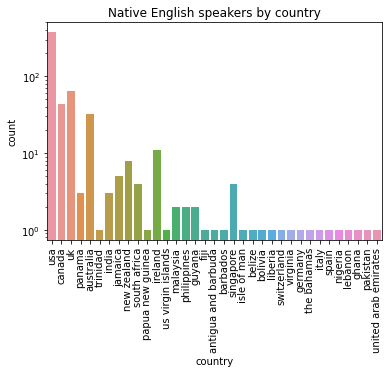

In [30]:
sns.countplot(x='country', data=english)
plt.yscale('log')
plt.xticks(rotation=90)
plt.title('Native English speakers by country')

In [31]:
english.birthplace.value_counts()

sydney, australia                        8
toronto, ontario, canada                 7
washington, district of columbia, usa    7
brooklyn, new york, usa                  6
chicago, illinois, usa                   6
                                        ..
duluth, georgia, usa                     1
suva, fiji                               1
poughkeepsie, new york, usa              1
lemington spa, warwickshire, uk          1
torrington, connecticut, usa             1
Name: birthplace, Length: 421, dtype: int64

In [32]:
english.birthplace.str.contains('usa').sum()

373

In [33]:
english.birthplace.str.contains('uk').sum()

67

In [34]:
english.birthplace.str.contains('canada').sum()

44

In [35]:
english.birthplace.str.contains('australia').sum()

32

The birthplace column is a bit hard to parse for country, since the column entries include cities, optional provinces/states, and country. However, the number of speakers from each country by birthplace seem to correspond to a high degree, when the birthplace column is filtered for the top 4 "countries".

# Audio Files
## Segmentation
Since the speakers read a fixed English passage with 4 sentences, I expect that the resulting audio files are going to be fairly long.

First, we will load a random file to see how long it is, and to examine how it can be segmented into smaller segments at pauses.

In [36]:
# Load a sample audio file - play the audio file and look at the waveform
# Choose a random sound file to examine
filename = random.choice(meta.filename)
filepath = 'recordings/recordings/' + filename + '.mp3'
print(filepath)

recordings/recordings/luxembourgeois1.mp3


In [37]:
ipd.Audio(filepath)

In [38]:
# Set sample rate to 16k, to fit with Vggish model
SAMP_RATE = 16000
y, sr = librosa.load(filepath, sr=SAMP_RATE)

Text(0.5, 1.0, 'Waveform of audio file')

<Figure size 1080x216 with 0 Axes>

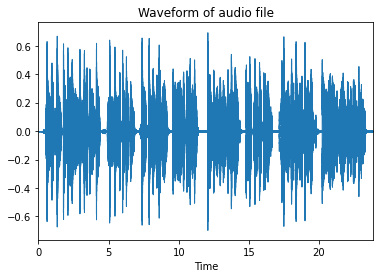

In [39]:
plt.figure(figsize=(15, 3))
plt.figure()
librosa.display.waveplot(y, sr=sr)
plt.title('Waveform of audio file')

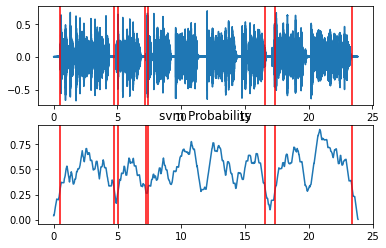

In [40]:
# https://github.com/tyiannak/pyAudioAnalysis/wiki/5.-Segmentation

# segments is a list of endpoints
segments = aS.silence_removal(y, SAMP_RATE, 0.020, 0.020, smooth_window = 1.0, weight = 0.15, plot = True)

In [41]:
print(segments)

[[0.5, 4.74], [5.0600000000000005, 7.2], [7.36, 16.580000000000002], [17.34, 23.400000000000002]]


In [42]:
# Segment the audio files at the pauses and return the segments in a dictionary
def get_segments(audio, samp_rate):
  segments = aS.silence_removal(audio, samp_rate, 0.020, 0.020, smooth_window = 1.0, weight = 0.15, plot = False)
  seg_files = {}
  for idx, seg in enumerate(segments):
    beg = int(seg[0] * samp_rate)
    ending = int(seg[1] * samp_rate)
    new_audio = audio[beg:ending]
    seg_files[idx] = new_audio
  return seg_files

### Comments on segmentation
Running the segmentation algorithm on a variety of different files elsewhere gives different results for different audio files. Some segments are really short, while others are longer. Most files are segmented into at least 4 segments, with some having 8-10 segments, many of which are very short.

While the original idea was to try to segment the files into approximately 4 segments, which correspond roughly to the 4 phrases in the text passage, these segments end up being (much) shorter than the files on which the VGGish model was trained.

At this point, my plan is to segment the files into 10s segments, which correspond to the length of the training files for VGGish. For most of the files in this data set, this will result in at least 2 segments, with up to 5 segments. Segmenting the files into fixed length segments can be done by index slicing on the original file, and don't involve outside functions.

In [43]:
def segment_10s(audio, sr):
  """ Load an audio file and divide into 10 second segments.
  Arguments: audio - the audio file; sr = sampling rate of the file
  Returns: a dictionary of the audio segments. Key is the index of segment, value is the segment.
  """
  seg_files ={}
  n_seg = int((len(audio)/sr)/10)
  for i in range(n_seg):
    segment = audio[10*i*sr:(i+1)*10*sr]
    seg_files[i] = segment
  return seg_files

In [44]:
# Test segment_10s fuction on the sample audio file
y_seg = segment_10s(y, SAMP_RATE)
print(y_seg.keys())

dict_keys([0, 1])


In [45]:
ipd.Audio(y_seg[0], rate=SAMP_RATE)

In [46]:
ipd.Audio(y_seg[1], rate=SAMP_RATE)

## Augment with noise
One way to make the model more robust is to add random noise to the audio files, which double the number of training files, and forces the model to focus on the relevant features while ignoring the noise.

In [47]:
def add_noise(audio):
    '''
    Add random noise to an audio file.
    Arguments: audio - the audio file
    Returns: the noisy audio file
    ''' 
    # Load random number generator
    rng = np.random.default_rng()
    # Generate random noise
    noise = rng.standard_normal(len(audio))
    # Choose weight of noise to add to file
    weights = [0.005, 0.01, 0.015]
    weight = random.choice(weights)
    # Add noise to file
    noisy_seg = audio + weight*noise

    return noisy_seg

In [48]:
# Test the add_noise function on the sample soundfile
y_noise = add_noise(y_seg[0])
ipd.Audio(y_noise, rate=SAMP_RATE)

## Extract mel spectrogram
Internally, the VGGish algorith converts the audiofile into a melspectrogram, which is the input to the first convolutional layer of the VGGish model.

This section of code generates mel spectrograms similar to those that will be generated by the VGGish model, for inspection.

In [49]:
# Mel spectrogram parameters
N_MEL_BANDS = 64
FREQ_MIN = 125
FREQ_MAX = 7500
HOP = 1667
WIN = 400
FFT = 512

In [50]:
def extract_mel_spec(audio, sr):
  mel = librosa.feature.melspectrogram(audio, sr, n_mels=N_MEL_BANDS, 
                                     fmin=FREQ_MIN, fmax=FREQ_MAX,
                                     hop_length=HOP, 
                                    n_fft=FFT) #win_length=WIN,
  return mel

In [51]:
# Try extract_mel_spec and plot
mel_spec = extract_mel_spec(y_seg[0], SAMP_RATE)
#mel_list = mel_spec.T.tolist()
#print("Spec: " , mel_spec.T.shape)
#print(type(mel_spec.T))

#print("List: " , len(mel_list), len(mel_list[0]))
#print(type(mel_list))

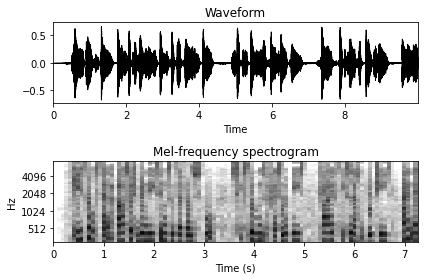

In [52]:
fig, axn = plt.subplots(2, 1)
librosa.display.waveplot(y_seg[0], sr=SAMP_RATE, ax=axn[0], color='k')
axn[0].set(title='Waveform')
 
mel_db = librosa.power_to_db(mel_spec, ref=np.max)
img = librosa.display.specshow(mel_db, x_axis='s', y_axis='mel', 
                               ax=axn[1], fmin=FREQ_MIN, fmax=FREQ_MAX,
                               cmap='gray_r', hop_length=HOP)#,
                               # n_fft=512) #win_length=win_size,
#fig.colorbar(img, ax=axn[1], format='%+2.0f dB')
axn[1].set(title="Mel-frequency spectrogram")
plt.tight_layout()

# Split data and load
While I want to add noise to the training data, I don't necessarily want to add noise to the testing data.

The first step here is to split the speakers into training and testing lists. The files in the training list will be segmented, then augmented with noise. The files in the testing list will be segmented.

- Edit out this section?

The training and testing data will be run through the VGGish model and the extracted features will be saved to a text file, so they can be reloaded more quickly.

Metadata about the files will be stored in a pandas dataframe and .csv file, which will track the filename, the segment number, whether the segment is the original or noisy version, and the gender of the speaker.

The mel spectrograms will be saved as a numpy array as the features. The labels will be saves a numpy array. Once the features and labels have been generated and saved as a numpy array, they can be loaded from the text file, instead of needing to be regenerated from the audio files.

## Procedure
- Filter meta_df to select desired files
-- gender classifier - all files
-- language classifier - top 10 files, with downsampled english files
- load training audio files
- segment in 10s chunks
- extract mel spectrogram of original segment
- add noise to segment
- extract mel spectrogram of noisy segement

In [53]:
# Split data into training and testing sets for gender analysis
data = meta[['sex', 'filename']]
x_train_names, x_test_names, y_train, y_test = train_test_split(data['filename'], 
                                                                                data['sex'], 
                                                                                test_size=0.25, 
                                                                                random_state=38, 
                                                                                stratify=data['sex'])
print(x_train_names.shape)

(1600,)


In [55]:
print(x_test_names.shape)

(534,)


# Format features for the training and testing sets

In [56]:
# Scale audio to fall between [-1, 1]
def normalize(audio):
  norm = audio/max(audio)
  return norm

In [58]:
def load_data(x, y, split='train', clf='gender'):  #df = x_train_temp or x_test_temp, which contain filenames in each set
  """First time through, load audio files, segment them, add noise.
  Arguments: 
  x - Series of filenames.
  y - Series of gender labels corresponding to x
  split - 'train' or 'test' - specify training or testing data, training data augments with noise, save and load filepaths
  clf - name of classifier, either 'gender' or 'lang10' to save and load files from appropriate folder
  Returns/Save labels, and metadata.
  After the first time, load the text files, since it is faster. """

  # if results are already in a text file or numpy array, load from there
  if os.path.isfile("data/{}/{}/meta.csv".format(clf, split)) and os.path.isfile("data/{}/{}/labels.npy".format(clf, split)):
    audio_seg = np.load("data/{}/{}/audio_seg.npy".format(clf,split))
    labels = np.load("data/{}/{}/labels.npy".format(clf, split))
    meta = pd.read_csv("data/{}/{}/meta.csv".format(clf, split))
    return audio_seg, labels, meta #, gender_X

  # If text files don't exist, cycle through the data and extract audio segments and labels
  meta = pd.DataFrame(columns=['sex', 'filename', 'segment_idx', 'is_noise'])
  audio_seg = []
  labels = []

  for i in range(y.shape[0]):  #each filename(row) in DF
    #load audio
    sex_string = y.iloc[i]
    if sex_string == 'female':
      sex_int = 0
    else: sex_int = 1

    filename = x.iloc[i]
    filepath = 'recordings/recordings/' + filename + '.mp3'
    audio, sr = librosa.load(filepath, sr=SAMP_RATE)
    audio = normalize(audio)

    # Segment audio file
    seg_files = segment_10s(audio, SAMP_RATE)

    # For each segment
    for key, val in seg_files.items():
      # Add segment index to gender metadata [sex, filename, segment_idx, noise]
      meta = meta.append({'sex':sex_int, 'filename':filename,'segment_idx':key,
                          'is_noise':0}, ignore_index=True)
      # Extract mel spectrogram
      #mel_spec = extract_mel_spec(val, SAMP_RATE)
      #mel_list = mel_spec.T.tolist()
    
      # Add sex label and mel spec to gender_train list/matrix
      audio_seg.append(val)
      labels.append(sex_int)

      if split=='train':
        # Add noise to segment
        val_noise = add_noise(val)

        # Add noisy segment index to gender metadata [sex, filename, segment_idx, noise]
        meta = meta.append({'sex':sex_int, 'filename':filename,'segment_idx':key,
                            'is_noise':1}, ignore_index=True)

        # Extract noisy mel spectrogram
        #mel_spec_noise = extract_mel_spec(val_noise, SAMP_RATE)  # is a np.array
        #mel_list_noise = mel_spec_noise.T.tolist()
    
        # Add sex label and mel spec to gender_train matrix
        audio_seg.append(val_noise)
        labels.append(sex_int)
    
  audio_seg = np.asarray(audio_seg)
  labels = np.asarray(labels)

  #Save arrays to text files
  np.save("data/{}/{}/audio_seg.npy".format(clf, split), audio_seg)
  np.save("data/{}/{}/labels.npy".format(clf, split), labels)
  meta.to_csv("data/{}/{}/meta.csv".format(clf, split))

  return audio_seg, labels, meta

In [ ]:
x_train_seg, y_train, x_train_meta = load_data(x_train_names, y_train, split='train', clf='gender')

In [ ]:
print("# training samples: ", x_train_seg.shape)
print("y has shape", y_train.shape)

X has shape (20, 96, 64)
y has shape (20,)


In [ ]:
x_test_seg, y_test, x_test_meta = load_data(x_test_names, y_test, split='test', clf='gender')
print("# training samples: ", x_test_seg.shape)
print("y_test has shape: ", y_test.shape)

X_test has shape (1206, 96, 64)
y_test has shape (1206,)


In [ ]:
# Nested dictionary to hold mel spectrograms for every segment of every file
#features_dict = {}
#noise_dict={}
#segment_dict={}

#for audio in df.filename:
#for i in range(x_train_temp.shape[0]):  #each row in DF
  #load audio
#  filename = x_train_temp.iloc[i, 3]
#  filepath = 'recordings/recordings/' + filename + '.mp3'
#  y, sr = librosa.load(filepath, sr=SAMP_RATE)
  # Add original filename as key in dict, add dict as value
#  features_dict[filename] = {'original':{}, 'noise':{}}
#  noise_dict[filename]={}

  # Segment audio
#  seg_dict = get_segments(y, SAMP_RATE)
#  segment_dict[filename] = seg_dict

  # Get mel spec from each segment
#  for key, val in seg_dict.items():
    # Extract mel spec from segment
#    mel_spec = librosa.feature.melspectrogram(val, SAMP_RATE)

    # Add mel_spec to features_dict
#    features_dict[filename]['original'][key] = mel_spec

    # Add noise to segment and extract mel_spec of noisy signal
#    rng = np.random.default_rng()
#    noise = rng.standard_normal(len(val))
#    noisy_seg = val + 0.015*noise
#    noise_dict[filename][key] = noisy_seg

#    noise_mel_spec = librosa.feature.melspectrogram(noisy_seg, SAMP_RATE)
#    features_dict[filename]['noise'][key] = noise_mel_spec

# Load the pretrained VGGish model from TensorFlowHub

In [ ]:
# Using a SavedModel from the TFHub in Keras
# https://www.tensorflow.org/hub/tf2_saved_model
# VGGish model, from https://tfhub.dev/google/vggish/1

# Link to the model on TFHub
hub_url = 'https://tfhub.dev/google/vggish/1'

# Load the model as a Keras model
vggish_model = hub.KerasLayer(hub_url)
vggish_model.trainable = False

In [ ]:
# Run one audiofile through the model to make sure it is running
sample_embed = vggish_model(x_train_seg[0])
print(vggish_embed.shape, vggish_embed.dtype)
vggish_embed.shape.assert_is_compatible_with([None, 128])

In [ ]:
## Extract embeddings from VGGish model for training and testing data.

In [ ]:
def extract_embeddings(data):
  embedding = []
  for i in range(len(data)):
    vggish_embed = vggish_model(data[i])
    embedding.append(vggish_embed)
  return np.asarray(embedding)

In [ ]:
x_train_embed = extract_embeddings(x_train_seg)
print(x_train_embed.shape)

In [ ]:
x_test_embed = extract_embeddings(x_test_seg)
print(x_test_embed.shape)

## Create a binary gender classifier
Takes the VGGish embeddings and predicts speaker gender

In [ ]:
genderClf = tf.keras.models.Sequential([tf.keras.layers.Dense(128, activation = 'relu'),
                              tf.keras.layers.Dense(64, activation = 'relu'),
                              tf.keras.layers.Dense(1, activation='sigmoid'),
                              tf.keras.layers.AveragePooling1D(pool_size=10, strides=None, padding="valid", data_format="channels_last")
                              ])
genderClf.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [ ]:
# Add early stopping to train classifier model; default is 10 epochs
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=2)

In [ ]:
history = genderClf.fit(x_train_embed, y_train, epochs=20, callbacks=[early_stopping_monitor], 
              validation_split=0.25, batch_size=32)

In [ ]:
genderClf.summary()

In [ ]:
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Use trained model to predict gender of test data

In [ ]:
y_pred = genderClf.predict(x_test_embed)
print(y_pred.shape)

In [ ]:
def pred_to_int(array, threshold):
  labels = []
  for i in range(len(array)):
    if array[i] > threshold:
      labels.append(1)  #'male'
    else: labels.append(0)  #'female'
  return labels

In [ ]:
gen_pred = pred_to_int(y_pred, 0.5)

In [ ]:
classification_report(y_test_label, gen_pred)

In [ ]:
confusion_matrix(y_test_label, gen_pred)

# The rest of this is not part of the model - eventually it should be deleted

Inputs
The model accepts a 1-D Tensor or NumPy array containing a waveform of arbitrary length, represented as mono 16 kHz float32 samples in the range [-1.0, +1.0]. Internally, we frame the waveform into sliding windows of 0.96 seconds with no overlap and then run the core of the model on a batch of these frames.

Outputs
The model returns a 2-D float32 Tensor of shape (N, 128) where N is the number of frames produced as described in the Inputs section above. Each row of the tensor is a 128-D embedding representation of the semantic content of the corresponding frame of audio.

In [ ]:
# tutorial on Tensorflow : https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub

import numpy as np
import os
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

#Download the classifier
#Use hub.KerasLayer to load a MobileNetV2 model from TensorFlow Hub. Any compatible image classifier model from tfhub.dev will work here.

classifier_model ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4" 

IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

# Load imaage
#Add a batch dimension, and pass the image to the model.

result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

predicted_class = np.argmax(result[0], axis=-1)
predicted_class

# Transfer learning
# Simple transfer learning
#But what if you want to train a classifier for a dataset with different classes? You can also use a model from TFHub to train a custom image classier by retraining the top layer of the model to recognize the classes in our dataset.

#Dataset
#For this example you will use the TensorFlow flowers dataset:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

#The simplest way to load this data into our model is using tf.keras.preprocessing.image.ImageDataGenerator,

#TensorFlow Hub's conventions for image models is to expect float inputs in the [0, 1] range. Use the ImageDataGenerator's rescale parameter to achieve this.
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

#The resulting object is an iterator that returns image_batch, label_batch pairs.
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

# Run the classifier on a batch of images
# Now run the classifier on the image batch.
result_batch = classifier.predict(image_batch)
result_batch.shape

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names


#Download the headless model
#TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.
#Any compatible image feature vector model from tfhub.dev will work here.
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" 

Create the feature extractor. Use trainable=False to freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

#Attach a classification head
#Now wrap the hub layer in a tf.keras.Sequential model, and add a new classification layer.

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(image_data.num_classes)
])

model.summary()
predictions = model(image_batch)
predictions.shape

Train the model
Use compile to configure the training process:

model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

Now use the .fit method to train the model.

To keep this example short train just 2 epochs. To visualize the training progress, use a custom callback to log the loss and accuracy of each batch individually, instead of the epoch average.

class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit(image_data, epochs=2,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[batch_stats_callback])

plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)


class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

label_id = np.argmax(label_batch, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path)

export_path


In [ ]:
# Tutorial on Tensorflow - how use a pretrained model

model = hub.load('https://tfhub.dev/google/yamnet/1')

# https://www.tensorflow.org/hub/tutorials/tf2_image_retraining
module_selection = ("mobilenet_v2_100_224", 224) 
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32 

# Define the model
## allow fine tuning or not
do_fine_tuning = False # or True, faster not to adjust weight

print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

# Train the model
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history


# Plot the model stats
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])


# Try out the model on an image from the validation data
def get_class_string_from_index(index):
   for class_string, class_index in valid_generator.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(valid_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

# save trained model
saved_model_path = "/tmp/saved_flowers_model"
tf.saved_model.save(model, saved_model_path)

In [ ]:
# VGGish Audio Embedding Colab example
!git clone https://github.com/tensorflow/models.git
!curl -O https://storage.googleapis.com/audioset/vggish_model.ckpt
!curl -O https://storage.googleapis.com/audioset/vggish_pca_params.npz
!ls
# Verify the location of the AudioSet source files
!ls models/research/audioset
# Copy the source files to the current directory.
!cp models/research/audioset/* .
# Run the test, which also loads all the necessary functions.
from vggish_smoke_test import *

# Using the VGGish System
import vggish_slim
import vggish_params
import vggish_input

def CreateVGGishNetwork(hop_size=0.96):   # Hop size is in seconds.
  """Define VGGish model, load the checkpoint, and return a dictionary that points
  to the different tensors defined by the model.
  """
  vggish_slim.define_vggish_slim()
  checkpoint_path = 'vggish_model.ckpt'
  vggish_params.EXAMPLE_HOP_SECONDS = hop_size
  
  vggish_slim.load_vggish_slim_checkpoint(sess, checkpoint_path)

  features_tensor = sess.graph.get_tensor_by_name(
      vggish_params.INPUT_TENSOR_NAME)
  embedding_tensor = sess.graph.get_tensor_by_name(
      vggish_params.OUTPUT_TENSOR_NAME)

  layers = {'conv1': 'vggish/conv1/Relu',
            'pool1': 'vggish/pool1/MaxPool',
            'conv2': 'vggish/conv2/Relu',
            'pool2': 'vggish/pool2/MaxPool',
            'conv3': 'vggish/conv3/conv3_2/Relu',
            'pool3': 'vggish/pool3/MaxPool',
            'conv4': 'vggish/conv4/conv4_2/Relu',
            'pool4': 'vggish/pool4/MaxPool',
            'fc1': 'vggish/fc1/fc1_2/Relu',
            'fc2': 'vggish/fc2/Relu',
            'embedding': 'vggish/embedding',
            'features': 'vggish/input_features',
         }
  g = tf.get_default_graph()
  for k in layers:
    layers[k] = g.get_tensor_by_name( layers[k] + ':0')
    
  return {'features': features_tensor,
          'embedding': embedding_tensor,
          'layers': layers,
         }

def ProcessWithVGGish(vgg, x, sr):
  '''Run the VGGish model, starting with a sound (x) at sample rate
  (sr). Return a whitened version of the embeddings. Sound must be scaled to be
  floats between -1 and +1.'''

  # Produce a batch of log mel spectrogram examples.
  input_batch = vggish_input.waveform_to_examples(x, sr)
  # print('Log Mel Spectrogram example: ', input_batch[0])

  [embedding_batch] = sess.run([vgg['embedding']],
                               feed_dict={vgg['features']: input_batch})

  # Postprocess the results to produce whitened quantized embeddings.
  pca_params_path = 'vggish_pca_params.npz'

  pproc = vggish_postprocess.Postprocessor(pca_params_path)
  postprocessed_batch = pproc.postprocess(embedding_batch)
  # print('Postprocessed VGGish embedding: ', postprocessed_batch[0])
  return postprocessed_batch[0]

# Test these new functions with the original test.
import tensorflow as tf
tf.reset_default_graph()
sess = tf.Session()

vgg = CreateVGGishNetwork(0.01)

# Generate a 1 kHz sine wave at 44.1 kHz (we use a high sampling rate
# to test resampling to 16 kHz during feature extraction).
num_secs = 3
freq = 1000
sr = 44100
t = np.linspace(0, num_secs, int(num_secs * sr))
x = np.sin(2 * np.pi * freq * t)  # Unit amplitude input signal

postprocessed_batch = ProcessWithVGGish(vgg, x, sr)

# print('Postprocessed VGGish embedding: ', postprocessed_batch[0])
expected_postprocessed_mean = 123.0
expected_postprocessed_std = 75.0
np.testing.assert_allclose(
    [np.mean(postprocessed_batch), np.std(postprocessed_batch)],
    [expected_postprocessed_mean, expected_postprocessed_std],
    rtol=rel_error)

def EmbeddingsFromVGGish(vgg, x, sr):
  '''Run the VGGish model, starting with a sound (x) at sample rate
  (sr). Return a dictionary of embeddings from the different layers
  of the model.'''
  # Produce a batch of log mel spectrogram examples.
  input_batch = vggish_input.waveform_to_examples(x, sr)
  # print('Log Mel Spectrogram example: ', input_batch[0])

  layer_names = vgg['layers'].keys()
  tensors = [vgg['layers'][k] for k in layer_names]
  
  results = sess.run(tensors,
                     feed_dict={vgg['features']: input_batch})

  resdict = {}
  for i, k in enumerate(layer_names):
    resdict[k] = results[i]
    
  return resdict

# Gender classifier
- binary options: logistic regression, sigmoid function?

In [ ]:
# Load the vggish model from the TF hub
# model = hub.load('https://tfhub.dev/google/vggish/1')

# Build a model
- Feature extraction from vggish
- Gender classifier layers

# Train the model

# Evaluate the results

# References
Data from: 
https://www.kaggle.com/rtatman/speech-accent-archive/notebooks

Inspiration and examples from:
https://www.kaggle.com/ejlok1/part-2-extracting-audio-features

Load data function modifed from:
https://www.thepythoncode.com/article/gender-recognition-by-voice-using-tensorflow-in-python